In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
np.random.seed(42)


"""
Designing Neural Network for the classification of tau hadronic decay and hard QCD jets

variable to use :  theta_J and N_T initially to segment phase space and then use lambda_J, r_2 and tau_31 to analyze the subspaces using multi-variate analysis
files given  : signal (tauhadronic_out.root) and background (hardqcd_200k_minpt50_out.root)
"""
variables = ["thetaJ", "trackno", "LambdaJ", "ecfr2", "tau31"] # choices informed by the paper

def create_df(file_name, label):
    file = uproot.open(f"../dataset/{file_name}.root")  # Corrected path
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")[variables]
    df["label"] = label
    return df

#create a parquet file from the root file
def write_parquet(file_name):
    file  = uproot.open(f"../dataset/{file_name}.root")  # Corrected path
    tree_name = list(file.keys())[0]
    tree = file[tree_name]
    df = tree.arrays(library="pd")
    df.to_parquet(f"../dataset/converted/converted_{file_name}.parquet", index=False)  # Save in /content/
    print(f"saved {file_name}.parquet")
    return

if __name__ == "__main__":

    signal_file = "tauhadronic1L_minpt50_out"
    background_file = "hardqcd_200k_minpt50_out2"

    # write_parquet(signal_file)
    # write_parquet(background_file)

    signal_df = create_df(signal_file, 1)
    background_df = create_df(background_file, 0)

    print(len(signal_df), len(background_df))

    write_parquet(signal_file)
    write_parquet(background_file)

    df = pd.concat([signal_df, background_df], axis=0)
    df = df.sample(frac=1).reset_index(drop=True)

    X = df[variables]
    y = df["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

27956 97708
saved tauhadronic1L_minpt50_out.parquet
saved hardqcd_200k_minpt50_out2.parquet
Training samples: 100531, Testing samples: 25133


In [3]:
df.head()

,thetaJ,trackno,LambdaJ,ecfr2,tau31,label
0,-0.044449,3.0,-0.226423,6.207169e-01,0.352259,0
1,-0.485420,1.0,-0.649732,1.462608e-07,0.000000,1
2,-0.099023,2.0,-0.284290,3.358686e-01,0.227576,0
3,-0.075547,8.0,-0.163599,1.187330e+00,0.545529,0
4,-0.616807,6.0,-0.206584,4.232076e-01,0.537610,0


In [4]:
df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [5]:
signal_df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [6]:
background_df.columns

Index(['thetaJ', 'trackno', 'LambdaJ', 'ecfr2', 'tau31', 'label'], dtype='object')

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)
    
class BetterNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(BetterNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return self.softmax(x)

hidden_dim = 256 # Number of hidden neurons
learning_rate = 5e-4  # Learning rate
batch_size = 64  # Batch size
epochs = 20  # Number of epochs

model = BetterNN(X_train.shape[1], hidden_dim, len(np.unique(y_train)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))  # Shuffle the training data
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


model.eval()
with torch.no_grad():
    y_prob = model(X_test_tensor)
    y_pred = torch.argmax(y_prob, axis=1)    
    y_prob = y_prob.numpy()[:,1]
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/20, Loss: 576.0176
Epoch 2/20, Loss: 562.2773
Epoch 3/20, Loss: 558.5045
Epoch 4/20, Loss: 557.3269
Epoch 5/20, Loss: 556.6895
Epoch 6/20, Loss: 555.1803
Epoch 7/20, Loss: 554.8448
Epoch 8/20, Loss: 553.9528
Epoch 9/20, Loss: 552.4192
Epoch 10/20, Loss: 552.2965
Epoch 11/20, Loss: 551.8148
Epoch 12/20, Loss: 550.9502
Epoch 13/20, Loss: 550.3027
Epoch 14/20, Loss: 550.4283
Epoch 15/20, Loss: 550.3958
Epoch 16/20, Loss: 549.4312
Epoch 17/20, Loss: 549.6278
Epoch 18/20, Loss: 549.3435
Epoch 19/20, Loss: 548.6260
Epoch 20/20, Loss: 548.7036
Accuracy: 0.9643
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     19657
           1       0.91      0.92      0.92      5476

    accuracy                           0.96     25133
   macro avg       0.95      0.95      0.95     25133
weighted avg       0.96      0.96      0.96     25133



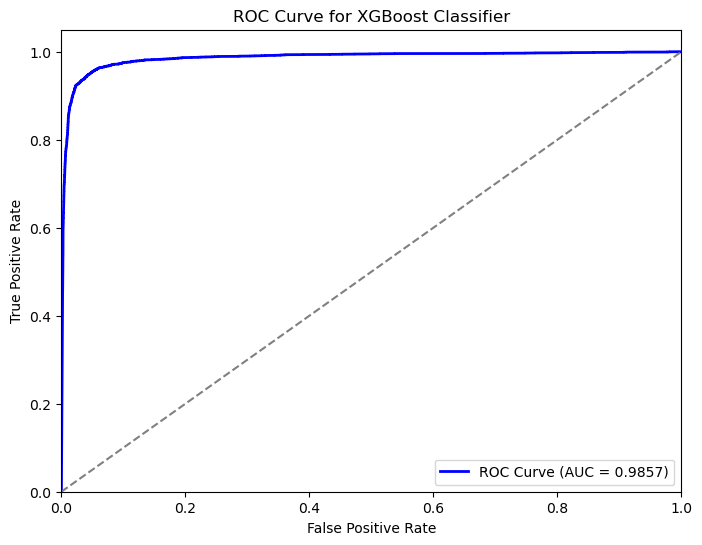

In [42]:
# Compute ROC curve and AUC
# AUC = 0.9813 for simple NN
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.show()